## 준비 단계

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.2 MB/s eta 0:00:00


In [ ]:
!wandb disabled -q

/bin/bash: line 1: wandb: command not found


In [ ]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# zip 파일 경로
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/EWHA/패턴인식/teamproject/underwater_plastics-20240521T044056Z-001.zip'

# zip 파일 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from glob import glob
from PIL import Image

## 사전 테스트

이미지 정규화 테스트

bounding box 회전 테스트

: x_center, y_center, width, height는 이미지 크기 416에 맞추어 정규화 되어 있음
: (좌상단 x, y와 우하단 x, y)으로 변경

In [ ]:
def rotate_point(point, angle):
    width = 416
    height = 416

    if angle == 0:
        rotated_point = point
    elif angle == 90:
        rotated_point = (point[1], width - point[0])
    elif angle == 180:
        rotated_point = (width - point[0], height - point[1])
    elif angle == 270:
        rotated_point = (height - point[1], point[0])
    else:
        raise ValueError("Invalid angle. Angle must be 0, 90, 180, or 270.")

    return rotated_point

def rotate_bbox_points(bbox_pts, angle):
    rotated_bbox_pts = [rotate_point(point, angle) for point in bbox_pts]
    return rotated_bbox_pts

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

import numpy as np

def convert_to_np_array(x_center, y_center, box_width, box_height):
    width = 416
    height = 416
    # Convert normalized coordinates to pixel values
    x_center *= width
    y_center *= height
    box_width *= width
    box_height *= height

    # Calculate the top-left and bottom-right corners of the bounding box
    x1 = int(x_center - (box_width / 2))
    y1 = int(y_center - (box_height / 2))
    x2 = int(x_center + (box_width / 2))
    y2 = int(y_center + (box_height / 2))

    # Return numpy array of coordinates
    return np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])


## 전처리 실행

- 명암, 색감, 선명도, 픽셀정규화 진행

- 0, 90, 180, 270 회전하여 데이터를 4배로 증가
  - -> 회전에 따른 bounding box 설정(함수 rotate_bbox)
  - 각도에 따라 이미지 파일 이름에 "rotate(각도)_"를 앞단에 추가하였음

In [ ]:
def rotate_image_and_bbox(image_path, text_path, angle):
    # image 데이터
    image = cv2.imread(image_path)
    # 이미지 회전
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

    # labels 데이터
    with open(text_path, 'r') as f:
      annotations = f.readlines()

    rotated_bboxes = []
    labels = []
    for annotation in annotations:
      # 클래스 레이블과 바운딩 박스 정보 추출
      label, x_center, y_center, box_width, box_height = map(float, annotation.split())
      bbox_pts = convert_to_np_array(x_center, y_center, box_width, box_height)
      rotated_bbox_pts = rotate_bbox_points(bbox_pts, angle)
      rotated_bboxes.append(rotated_bbox_pts)
      labels.append(label)

    # 회전된 이미지와 바운딩 박스 좌표 반환
    #print(type(rotated_bboxes))
    #print(type(labels))
    rotated_bbox_pts = []
    for i in range(len(rotated_bboxes)):
      # 최소 및 최대 좌표 계산
      x_min = min(point[0] for point in rotated_bboxes[i])
      y_min = min(point[1] for point in rotated_bboxes[i])
      x_max = max(point[0] for point in rotated_bboxes[i])
      y_max = max(point[1] for point in rotated_bboxes[i])
      x_center = (x_min + x_max) / 2
      y_center = (y_min + y_max) / 2
      width = x_max - x_min
      height = y_max - y_min
      # 이미지 크기로 정규화
      x_center /= 416
      y_center /= 416
      width /= 416
      height /= 416
      rotated_bbox_pts.append([x_center,y_center,width,height])
      print(rotated_bbox_pts)

    return rotated_image, rotated_bbox_pts, labels

In [ ]:
import cv2
import os
import json

for data in ['train']:

  # 이미지가 저장된 폴더 경로
  images_folder = f'/content/drive/MyDrive/sample_images/underwater_plastics/{data}/images'
  # 텍스트 파일이 저장된 폴더 경로/content/drive/MyDrive/sample_images/underwater_plastics/test/images
  labels_folder = f'/content/drive/MyDrive/sample_images/underwater_plastics/{data}/labels'

  # 새로운 이미지를 저장할 폴더 경로
  new_images_folder = f'/content/drive/MyDrive/preprocessed_data_/{data}/images'
  new_labels_folder = f'/content/drive/MyDrive/preprocessed_data_/{data}/labels'

  # 새로운 폴더 생성
  os.makedirs(new_images_folder, exist_ok=True)
  os.makedirs(new_labels_folder, exist_ok=True)

  # 파일 목록 가져오기
  image_files = os.listdir(images_folder)
  # label_files = os.listdir(labels_folder)

  json_data = {}
  num=1
  for image_file in image_files:
      # 이미지/라벨 불러오기
      image_path = os.path.join(images_folder, image_file)
      text_path = os.path.join(labels_folder, image_file[:-3])
      text_path += 'txt'

      # 회전 각도 설정
      angles = [0,90, 180, 270]

      # 각각의 각도에 대해 이미지 회전과 바운딩 박스 조정
      for angle in angles:
          try:
            rotated_image, rotated_bbox_pts, labels = rotate_image_and_bbox(image_path, text_path, angle)

            # 이미지 전처리
            # 명암 조절
            alpha = 0.7  # 명암 조절 정도, 1보다 크면 밝게, 작으면 어둡게
            beta = 10  # 밝기 조절 정도
            adjusted_image = cv2.convertScaleAbs(rotated_image, alpha=alpha, beta=beta)

            # 파란끼를 줄이기 위해 BGR에서 LAB 색 공간으로 변환
            lab_image = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2LAB)
            # LAB 색 공간에서 각 채널 분리
            l, a, b = cv2.split(lab_image)
            a = cv2.add(a, 10)
            b = cv2.add(b, -10)
            adjusted_lab_image = cv2.merge([l, a, b])
            # LAB에서 다시 BGR로 변환
            color_adjusted_image = cv2.cvtColor(adjusted_lab_image, cv2.COLOR_LAB2BGR)

            # 선명도 조정 (양방향 필터링)
            total_adjusted_image = cv2.bilateralFilter(color_adjusted_image, 9, 75, 75)

            # 최종 이미지 저장
            total_adjusted_image_filename = f"{data}_rotated{angle}_{num}.jpg"
            total_adjusted_image_filepath = os.path.join(new_images_folder, total_adjusted_image_filename)
            cv2.imwrite(total_adjusted_image_filepath, total_adjusted_image)

            # 회전된 바운딩 박스 좌표 저장
            total_adjusted_label_filename = f"{data}_rotated{angle}_{num}.txt"
            total_adjusted_label_filepath = os.path.join(new_labels_folder, total_adjusted_label_filename)
            print(total_adjusted_label_filepath)
            with open(total_adjusted_label_filepath, 'w') as f:
                for i in range(len(rotated_bbox_pts)):
                    # 바운딩 박스 좌표 추출
                    x1, y1, x2, y2 = rotated_bbox_pts[i]

                    rotated_label = labels[i]
                    print(rotated_label)
                    bbox_str = f"{rotated_label} {x1} {y1} {x2} {y2}\n"
                    f.write(bbox_str)

            # #JSON 데이터 저장
            # rotated_bbox_pts = [[int(coord) for coord in point] for point in rotated_bbox_pts]

            # key = f"{data}_rotated{angle}_{num}"
            # json_data[key] = {
            #     "original_image": image_path,
            #     "image": total_adjusted_image_filepath,
            #     "text": total_adjusted_label_filepath,
            #     "bbox": rotated_bbox_pts,
            #     "label": labels}

            num+=1

          except IndexError:
            print(f"Error 발생: {data}_{num}_{image_file}_{angle}")
            pass

          print(f"{data}_{num}_{image_file}_회전한 이미지와 바운딩 박스 좌표 저장 완료")

  # # JSON 파일로 저장
  # output_json_path = f'/content/drive/MyDrive/preprocessed_data_/dataset_{data}.json'
  # with open(output_json_path, 'w') as json_file:
  #     json.dump(json_data, json_file, indent=5)

[[0.45552884615384615, 0.5865384615384616, 0.3629807692307692, 0.41346153846153844]]
/content/drive/MyDrive/preprocessed_data_/train/labels/train_rotated0_1.txt
9.0
train_2_uwg_g-867__fliph_jpg.rf.77997cf12260a845edeb6c93944084ab.jpg_회전한 이미지와 바운딩 박스 좌표 저장 완료
[[0.5865384615384616, 0.5444711538461539, 0.41346153846153844, 0.3629807692307692]]
/content/drive/MyDrive/preprocessed_data_/train/labels/train_rotated90_2.txt
9.0
train_3_uwg_g-867__fliph_jpg.rf.77997cf12260a845edeb6c93944084ab.jpg_회전한 이미지와 바운딩 박스 좌표 저장 완료
[[0.5444711538461539, 0.41346153846153844, 0.3629807692307692, 0.41346153846153844]]
/content/drive/MyDrive/preprocessed_data_/train/labels/train_rotated180_3.txt
9.0
train_4_uwg_g-867__fliph_jpg.rf.77997cf12260a845edeb6c93944084ab.jpg_회전한 이미지와 바운딩 박스 좌표 저장 완료
[[0.41346153846153844, 0.45552884615384615, 0.41346153846153844, 0.3629807692307692]]
/content/drive/MyDrive/preprocessed_data_/train/labels/train_rotated270_4.txt
9.0
train_5_uwg_g-867__fliph_jpg.rf.77997cf12260a845edeb6

KeyboardInterrupt: 

- dataset에서 key의 값은 다음과 같은 형식을 가진다.

- {데이터 유형}\_{회전각도}\_{원시 데이터 순서}
- ex) train_rotate0_1


In [ ]:
import glob

def count_files_in_directory(directory_path):
    # 모든 파일을 검색하는 패턴 사용
    files = glob.glob(os.path.join(directory_path, '*'))
    return len([file for file in files if os.path.isfile(file)])

directory_path = '/content/drive/MyDrive/preprocessed_data_/train/labels'
file_count = count_files_in_directory(directory_path)
print(f"Number of files in directory '{directory_path}': {file_count}")

Number of files in directory '/content/drive/MyDrive/preprocessed_data_/train/labels': 14512


In [ ]:
def read_labels(label_file_path):
    with open(label_file_path, 'r') as file:
        labels = file.readlines()
    return [label.strip() for label in labels]

In [ ]:
# 예시 디렉토리와 라벨 파일 경로
directory_path = '/content/drive/MyDrive/preprocessed_data_/test/images/test_rotated0_2001.jpg'
label_file_path = '/content/drive/MyDrive/preprocessed_data_/test/labels/test_rotated0_2001.txt'

# 라벨 파일 읽기
labels = read_labels(label_file_path)
print("Labels:")
for label in labels:
    print(label)

Labels:
11.0 0.5108173076923077 0.3016826923076923 0.27163461538461536 0.3245192307692308


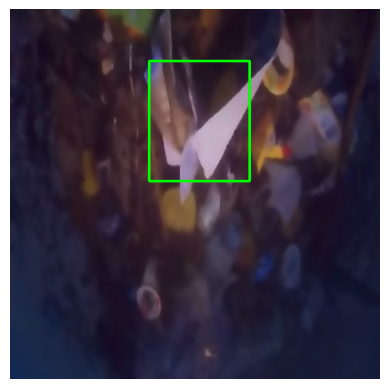

In [ ]:
import cv2
import matplotlib.pyplot as plt

def parse_yolo_label(label):
    data = label.split()
    class_id = int(float(data[0]))
    x_center = float(data[1])
    y_center = float(data[2])
    width = float(data[3])
    height = float(data[4])
    return class_id, x_center, y_center, width, height

def draw_bounding_box(image, x_center, y_center, width, height):
    image_height, image_width, _ = image.shape
    x_center *= image_width
    y_center *= image_height
    width *= image_width
    height *= image_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# 이미지 경로
image_path = '/content/drive/MyDrive/preprocessed_data_/test/images/test_rotated0_2001.jpg'
image = cv2.imread(image_path)

# 라벨 파일 읽기 및 바운딩 박스 그리기
for label in labels:
    class_id, x_center, y_center, width, height = parse_yolo_label(label)
    draw_bounding_box(image, x_center, y_center, width, height)

# 결과 이미지 표시
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Labels:
11.0 0.3016826923076923 0.4891826923076923 0.3245192307692308 0.27163461538461536


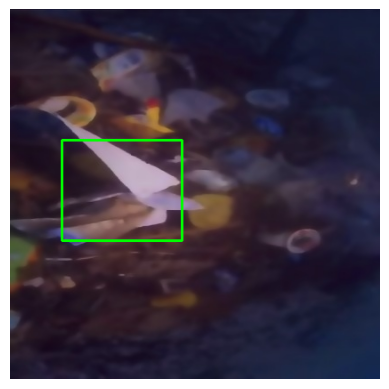

In [ ]:
label_file_path = '/content/drive/MyDrive/preprocessed_data_/test/labels/test_rotated90_2002.txt'

# 라벨 파일 읽기
labels = read_labels(label_file_path)
print("Labels:")
for label in labels:
    print(label)

image_path = '/content/drive/MyDrive/preprocessed_data_/test/images/test_rotated90_2002.jpg'
image = cv2.imread(image_path)

# 라벨 파일 읽기 및 바운딩 박스 그리기
for label in labels:
    class_id, x_center, y_center, width, height = parse_yolo_label(label)
    draw_bounding_box(image, x_center, y_center, width, height)

# 결과 이미지 표시
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Labels:
11.0 0.4891826923076923 0.6983173076923077 0.27163461538461536 0.3245192307692308


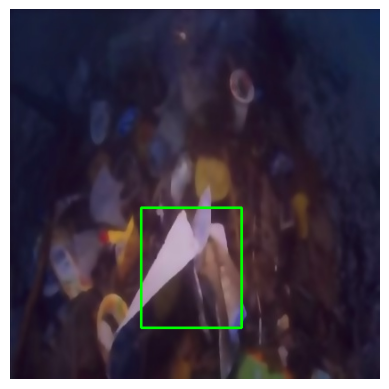

In [ ]:
label_file_path = '/content/drive/MyDrive/preprocessed_data_/test/labels/test_rotated180_2003.txt'

# 라벨 파일 읽기
labels = read_labels(label_file_path)
print("Labels:")
for label in labels:
    print(label)

image_path = '/content/drive/MyDrive/preprocessed_data_/test/images/test_rotated180_2003.jpg'
image = cv2.imread(image_path)

# 라벨 파일 읽기 및 바운딩 박스 그리기
for label in labels:
    class_id, x_center, y_center, width, height = parse_yolo_label(label)
    draw_bounding_box(image, x_center, y_center, width, height)

# 결과 이미지 표시
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Labels:
11.0 0.6983173076923077 0.5108173076923077 0.3245192307692308 0.27163461538461536


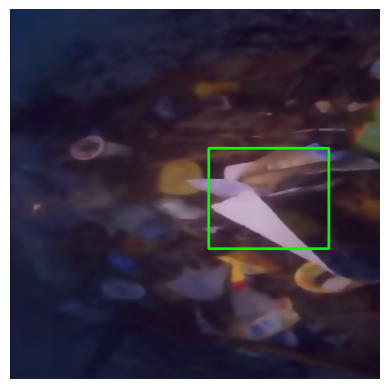

In [ ]:
label_file_path = '/content/drive/MyDrive/preprocessed_data_/test/labels/test_rotated270_2004.txt'

# 라벨 파일 읽기
labels = read_labels(label_file_path)
print("Labels:")
for label in labels:
    print(label)

image_path = '/content/drive/MyDrive/preprocessed_data_/test/images/test_rotated270_2004.jpg'
image = cv2.imread(image_path)

# 라벨 파일 읽기 및 바운딩 박스 그리기
for label in labels:
    class_id, x_center, y_center, width, height = parse_yolo_label(label)
    draw_bounding_box(image, x_center, y_center, width, height)

# 결과 이미지 표시
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

끝